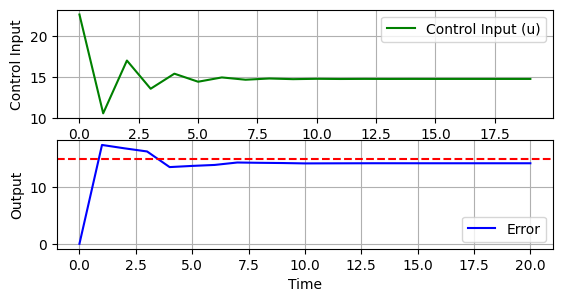

In [147]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider


# ARX model parameters
a1, a2, b1 = 0.5, -0.3, 0.7
Q = 2
R = 0.08
Qi = 0.015
# MPC parameters
horizon = 60  # Prediction horizon
ref = 15

# Initialize system state, last control input, and integral of error
y_current = 0
u_last = 0
integral_error = 0

# Store history of control inputs and system states
u_history = []
y_history = [y_current]
error_history = []

sim_time = 20

for t in range(sim_time):
    # Define variables for MPC
    U = ca.SX.sym('U', horizon)
    Y = ca.SX.sym('Y', horizon)
    E = ca.SX.sym('E', horizon)
    
    
    # Cost function and constraints
    cost = 0
    error_history = []
    integral_error_step = 0
    for k in range(horizon):
        y_prev1 = 0 if k == 0 else Y[k-1]
        y_prev2 = 0 if k <= 1 else Y[k-2]
        u_prev = u_last if k == 0 else U[k-1]
        Y[k] = a1 * y_prev1 + a2 * y_prev2 + b1 * u_prev

        integral_error_step += Y[k] - ref
        E[k] = integral_error_step

        cost += Q * (Y[k] - ref)**2 + R * U[k]**2 + Qi*(E[k]**2)


    # Optimization problem
    opts = {
        'ipopt.print_level': 0, 
        'print_time': 0,
        'ipopt.tol': 1e-8,           
    }

    nlp = {'x': ca.vertcat(U), 'f': cost}
    solver = ca.nlpsol('solver', 'ipopt', nlp, opts)

    # Initial guess and bounds for control inputs
    lbx = 0 * np.ones(horizon)
    ubx = 50* np.ones(horizon)

    # Solve MPC problem
    sol = solver(x0=10, lbx=lbx, ubx=ubx)
    u_optimized = sol['x'].full().flatten()

    # Apply the first control input to the system
    u_current = u_optimized[0]
    u_history.append(u_current)

    # Update the system state, last control input, and integral of error
    y_current = a1 * y_history[-1] + a2 * (y_history[-2] if len(y_history) > 1 else 0) + b1 * u_current*1.1
    y_history.append(y_current)
    u_last = u_current
    integral_error =0
    error_history.append(y_current)

# Plotting the control input history
plt.subplot(3, 1, 2)  # Second subplot in a 3 row layout
plt.plot(u_history, label='Control Input (u)', color='g')
plt.xlabel('Time')
plt.ylabel('Control Input')
plt.legend()
plt.grid(True)

# Plotting the error history
plt.subplot(3, 1, 3)  # Third subplot in a 3 row layout
plt.plot(y_history, label='Error', color='b')
plt.axhline(y = ref, color = 'r', linestyle = '--') 
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
